In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
import os
from tensorflow.keras.models import load_model
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import confusion_matrix, classification_report
import librosa
from librosa.display import specshow

In [3]:
# load all models by fold

model_dict = {}

for i in range(1,11):
    model_dict[i] = load_model('../models/mels_2/mels_basic_cnn_fold{}.hdf5'.format(i))

In [4]:
labels = np.array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

In [5]:
#load data for splitting by test

vec_type = 'mels'
data_path = os.path.join('../pickles', 'urbansound_'+ vec_type + '.p')

with open(data_path, 'rb') as handle:
    data = pickle.load(handle)

X, y, folds = data[0], data[1], data[2]

X = X.reshape(X.shape[0], 60, 174, 1)

In [6]:
# build dataframe to store predictions for each fold, for each sample 
# not all samples will have fold
metadata = pd.read_csv('../UrbanSound8K/metadata/UrbanSound8K.csv')

In [7]:
meta = metadata.drop(columns=['fsID', 'start', 'end', 'salience'])
meta

,slice_file_name,fold,classID,class
0,100032-3-0-0.wav,5,3,dog_bark
1,100263-2-0-117.wav,5,2,children_playing
2,100263-2-0-121.wav,5,2,children_playing
3,100263-2-0-126.wav,5,2,children_playing
4,100263-2-0-137.wav,5,2,children_playing
...,...,...,...,...
8727,99812-1-2-0.wav,7,1,car_horn
8728,99812-1-3-0.wav,7,1,car_horn
8729,99812-1-4-0.wav,7,1,car_horn
8730,99812-1-5-0.wav,7,1,car_horn


Important Note: classID relates to how 'y' was encoded

In [8]:
meta.classID.unique()

array([3, 2, 1, 0, 9, 6, 8, 5, 7, 4])

In [9]:
y_df = pd.DataFrame(y)
y_df

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
8727,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8728,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8729,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8730,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
all_preds = np.zeros((8732, 10))

In [11]:
logo = LeaveOneGroupOut()
#recreate fold indices used to train and test models. Use preds on test set 



for train_idx, test_idx in logo.split(X, y, folds):
    
    _, X_test, _, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]
    fold = folds[test_idx][0]
    
    #load model
    model = model_dict[fold]
    
    
    #make preds
    #each sample should have a 10 dimensional pred
    fold_pred = model.predict_proba(X_test)
    print('fold pred shape: ', fold_pred.shape)
    
    #stack preds on earlier samples
    all_preds[test_idx, :] = fold_pred
#     print("samples_preds shape: ", samples_preds.shape)
    


fold pred shape:  (873, 10)
fold pred shape:  (888, 10)
fold pred shape:  (925, 10)
fold pred shape:  (990, 10)
fold pred shape:  (936, 10)
fold pred shape:  (823, 10)
fold pred shape:  (838, 10)
fold pred shape:  (806, 10)
fold pred shape:  (816, 10)
fold pred shape:  (837, 10)


In [12]:
all_preds

array([[1.44605894e-09, 9.67026725e-02, 6.37282646e-05, ...,
        7.85993564e-08, 1.60660842e-04, 3.25082488e-06],
       [1.44291714e-01, 5.82792796e-02, 1.36796847e-01, ...,
        1.08494662e-01, 1.49226397e-01, 9.73597243e-02],
       [1.18917771e-01, 4.48139720e-02, 2.03481719e-01, ...,
        8.62784907e-02, 1.79640934e-01, 9.26425904e-02],
       ...,
       [2.13910863e-02, 2.38947839e-01, 1.80756271e-01, ...,
        1.59229934e-02, 4.52184863e-02, 2.35293493e-01],
       [3.32667073e-03, 1.96384177e-01, 2.41750449e-01, ...,
        3.53502408e-02, 1.18941277e-01, 1.68169215e-02],
       [3.12307719e-02, 2.55324900e-01, 1.09596804e-01, ...,
        4.22872826e-02, 2.82030910e-01, 6.45810217e-02]])

In [13]:
pred_classes = np.argmax(all_preds, axis=1)
pred_classes.shape

(8732,)

In [14]:
meta['predID'] = pred_classes
meta

,slice_file_name,fold,classID,class,predID
0,100032-3-0-0.wav,5,3,dog_bark,3
1,100263-2-0-117.wav,5,2,children_playing,8
2,100263-2-0-121.wav,5,2,children_playing,2
3,100263-2-0-126.wav,5,2,children_playing,2
4,100263-2-0-137.wav,5,2,children_playing,2
...,...,...,...,...,...
8727,99812-1-2-0.wav,7,1,car_horn,2
8728,99812-1-3-0.wav,7,1,car_horn,1
8729,99812-1-4-0.wav,7,1,car_horn,1
8730,99812-1-5-0.wav,7,1,car_horn,2


In [15]:
target_names = []
id2name = {}
for i in range(10):
    name = meta[meta['classID'] == i]['class'].iloc[0]
    target_names.append(name)
    id2name[i] = name
print(target_names)

['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']


In [16]:
id2name

{0: 'air_conditioner',
 1: 'car_horn',
 2: 'children_playing',
 3: 'dog_bark',
 4: 'drilling',
 5: 'engine_idling',
 6: 'gun_shot',
 7: 'jackhammer',
 8: 'siren',
 9: 'street_music'}

In [17]:
meta['pred_class'] = meta['predID'].map(id2name)
meta

,slice_file_name,fold,classID,class,predID,pred_class
0,100032-3-0-0.wav,5,3,dog_bark,3,dog_bark
1,100263-2-0-117.wav,5,2,children_playing,8,siren
2,100263-2-0-121.wav,5,2,children_playing,2,children_playing
3,100263-2-0-126.wav,5,2,children_playing,2,children_playing
4,100263-2-0-137.wav,5,2,children_playing,2,children_playing
...,...,...,...,...,...,...
8727,99812-1-2-0.wav,7,1,car_horn,2,children_playing
8728,99812-1-3-0.wav,7,1,car_horn,1,car_horn
8729,99812-1-4-0.wav,7,1,car_horn,1,car_horn
8730,99812-1-5-0.wav,7,1,car_horn,2,children_playing


In [18]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontweight='bold', fontsize=17, y=1.06)
    plt.colorbar(fraction=.045)
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=70)
    plt.yticks(tick_marks, target_names, fontsize=14)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)


In [19]:
cm =confusion_matrix(meta.classID, meta.predID)
# np.set_printoptions(precision=2)
# print('Confusion matrix, without normalization')
# print(cm)
# plt.figure(figsize=(10, 10))
# plot_confusion_matrix(cm)


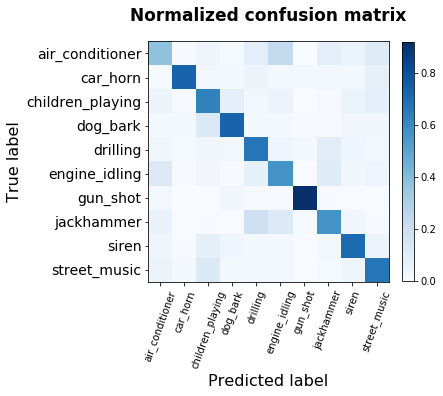

In [20]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# print('Normalized confusion matrix')
# print(cm_normalized)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix', cmap='Blues')
plt.savefig('../img/confmat_2.png', bbox_inches='tight', dpi=256)

In [21]:
print(classification_report(meta['class'], meta['pred_class']))

                  precision    recall  f1-score   support

 air_conditioner       0.49      0.38      0.43      1000
        car_horn       0.82      0.73      0.78       429
children_playing       0.58      0.63      0.61      1000
        dog_bark       0.78      0.73      0.76      1000
        drilling       0.59      0.67      0.63      1000
   engine_idling       0.51      0.57      0.54      1000
        gun_shot       0.89      0.92      0.91       374
      jackhammer       0.62      0.57      0.59      1000
           siren       0.70      0.71      0.71       929
    street_music       0.64      0.67      0.66      1000

        accuracy                           0.64      8732
       macro avg       0.66      0.66      0.66      8732
    weighted avg       0.64      0.64      0.63      8732



In [22]:
### loading 'best' model
# model = load_model('models/froms3_mels_basic_cnn_fold1.hdf5')

drilling


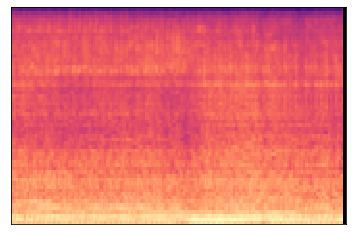

In [23]:
### examining a correct prediction
i = 4244
cls = meta.iloc[i, 3]
samp_1 = librosa.power_to_db(X[i, :, :, 0] )
print(cls)
specshow(samp_1, cmap='magma')
plt.savefig('../img/{}{}_right.png'.format(cls, i), dpi=256, bbox_inches='tight', transparent=True)

In [24]:
meta[(meta['class'] == 'street_music') & (meta['pred_class'] == 'street_music')]

,slice_file_name,fold,classID,class,predID,pred_class
94,101848-9-0-0.wav,7,9,street_music,9,street_music
95,101848-9-0-1.wav,7,9,street_music,9,street_music
96,101848-9-0-2.wav,7,9,street_music,9,street_music
97,101848-9-0-3.wav,7,9,street_music,9,street_music
98,101848-9-0-8.wav,7,9,street_music,9,street_music
...,...,...,...,...,...,...
8680,99180-9-0-7.wav,1,9,street_music,9,street_music
8717,99710-9-0-11.wav,6,9,street_music,9,street_music
8720,99710-9-0-2.wav,6,9,street_music,9,street_music
8721,99710-9-0-5.wav,6,9,street_music,9,street_music


engine_idling
pred:  engine_idling


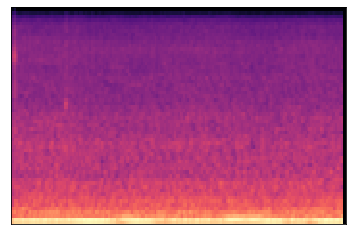

In [25]:
### examining misses
i = 8531
cls = meta.iloc[i, 3]
prd = meta.iloc[i, 5]
samp_1 = librosa.power_to_db(X[i, :, :, 0] )
print(cls)
print("pred: ", prd)
specshow(samp_1, cmap='magma')
plt.savefig('../img/{}{}_wrong.png'.format(cls, i), dpi=256, bbox_inches='tight', transparent=True)

In [26]:
from IPython.display import Audio

In [27]:
#street music 1
Audio('../UrbanSound8K/audio/fold7/101848-9-0-0.wav')

In [28]:
Audio('../UrbanSound8K/audio/fold1/99180-9-0-7.wav')

In [29]:
Audio('../UrbanSound8K/audio/fold6/99710-9-0-11.wav')

In [30]:
Audio('../UrbanSound8K/audio/fold6/99710-9-0-12.wav')

In [31]:
Audio('../UrbanSound8K/audio/fold7/101848-9-0-8.wav')

In [32]:
meta[meta['classID'] ==9]

,slice_file_name,fold,classID,class,predID,pred_class
94,101848-9-0-0.wav,7,9,street_music,9,street_music
95,101848-9-0-1.wav,7,9,street_music,9,street_music
96,101848-9-0-2.wav,7,9,street_music,9,street_music
97,101848-9-0-3.wav,7,9,street_music,9,street_music
98,101848-9-0-8.wav,7,9,street_music,9,street_music
...,...,...,...,...,...,...
8718,99710-9-0-12.wav,6,9,street_music,1,car_horn
8719,99710-9-0-16.wav,6,9,street_music,3,dog_bark
8720,99710-9-0-2.wav,6,9,street_music,9,street_music
8721,99710-9-0-5.wav,6,9,street_music,9,street_music


In [33]:
single_pred = all_preds[0]
class_preds = {id2name[k]:single_pred[k] for k in id2name}
class_preds

{'air_conditioner': 1.4460589392584211e-09,
 'car_horn': 0.09670267254114151,
 'children_playing': 6.372826464939862e-05,
 'dog_bark': 0.9030522704124451,
 'drilling': 2.5026308136943953e-08,
 'engine_idling': 3.0027936190890614e-06,
 'gun_shot': 1.4209476830728818e-05,
 'jackhammer': 7.859935635678994e-08,
 'siren': 0.00016066084208432585,
 'street_music': 3.2508248750673374e-06}

In [80]:
class_names = ['Air conditioner', 'Car horn', 'Children playing',
            'Dog bark', 'Drilling', 'Engine idling', 'Gun shot',
            'Jackhammer', 'Siren','Street music']

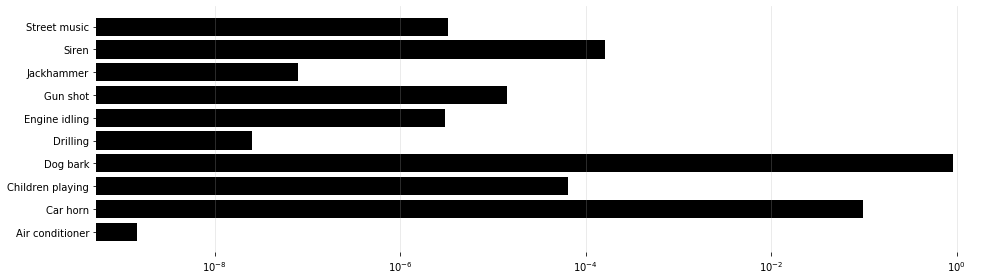

In [93]:
fig, ax = plt.subplots(figsize=(14,4))
ax.barh(range(10), single_pred, color='black', tick_label=class_names, log=True)
# for item in [fig, ax]:
#     item.patch.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()